In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time

In [253]:
import hackeeg
from hackeeg import ads1299
SERIAL_PORT_PATH = "/dev/cu.usbmodem142201"
SAMPLES_PER_SECOND = ads1299.HIGH_RES_250_SPS
GAIN = ads1299.GAIN_24X
CHANNELS = 8

In [254]:
# Configure ADS1299
hackeeg = hackeeg.HackEEGBoard(serial_port_path=SERIAL_PORT_PATH)
hackeeg.connect()
hackeeg.blink_board_led()
hackeeg.sdatac()
hackeeg.reset()
hackeeg.disable_all_channels()

# Set sampling rate
hackeeg.wreg(ads1299.CONFIG1, SAMPLES_PER_SECOND | ads1299.CONFIG1_const)

{'STATUS_CODE': 200, 'STATUS_TEXT': 'Ok'}

In [255]:
# Enable and configure channels for offset measurement
for i in range(1, 9):
    hackeeg.wreg(ads1299.CHnSET + i, ads1299.SHORTED | GAIN)

# Set internal voltage reference
hackeeg.wreg(ads1299.CONFIG3, ads1299.PD_REFBUF | ads1299.CONFIG3_const)


# Measure offset continuously for 5 seconds
#hackeeg.messagepack_mode()
hackeeg.blink_board_led()
hackeeg.start()
hackeeg.rdatac()

print("Start")

offset = []
t_end = time.time() + 5
while time.time() < t_end:
    result = hackeeg.read_rdatac_response()
    if result:
        offset.append(result)
    else:
        print("no data to decode")
        print(f"result: {result}")

print("Sampling complete")

hackeeg.sdatac()

try:
    i = 0
    while result != {}:
        result = hackeeg.read_rdatac_response()
        i += 1
except:
    pass
print(i, "samples flushed")

Start
Sampling complete

json decode error: 
1 samples flushed


In [256]:
# Process offset data
channel_offset = np.empty((8, len(offset)))
for i, s in enumerate(offset):
    dataKey = s.get(hackeeg.MpDataKey)
    if dataKey:
        data = s.get('channel_data')
        for channel in range(8):
            channel_offset[channel, i] = data[channel]
channel_offset = channel_offset.astype(np.float64)
channel_offset = np.median(channel_offset, axis=1)
channel_offset

array([ -886., -1246.,  -874.,  -856., -1094.,  -902.,  -737.,  -887.])

In [257]:
# Re-configure ADS1299 for EMG measurement
#ackeeg.reset()
#hackeeg.disable_all_channels()

# Set sampling rate
#hackeeg.wreg(ads1299.CONFIG1, SAMPLES_PER_SECOND | ads1299.CONFIG1_const)

# Enable and configure channels
#for i in range(1, 9):
#    hackeeg.wreg(ads1299.CHnSET + i, ads1299.SHORTED | GAIN)

# Differential mode - each channel is the differential voltage between adjacent electrodes
# hackeeg.wreg(ads1299.MISC1, ads1299.MISC1_const)
# For single-ended mode, uncomment the following line to set the SRB1 bit,
# which sends mid-supply voltage to the N inputs
# hackeeg.wreg(ads1299.MISC1, ads1299.SRB1 | ads1299.MISC1_const)


# Choose bias as an average of all channels but channel 8
# hackeeg.wreg(ads1299.BIAS_SENSP, 0b11111111)
# hackeeg.wreg(ads1299.BIAS_SENSN, 0b11111111)
# Use internal BIASREF signal source and turn on bias amplifier
# route BIASOUT to bias electrode: JP9: 1-2, JP6: NC (not connected)
# route BIASOUT to BIASIN: JP9: 2-3
# hackeeg.wreg(ads1299.CONFIG3, ads1299.PD_REFBUF | ads1299.BIASREF_INT | ads1299.PD_BIAS | ads1299.CONFIG3_const)
#hackeeg.wreg(ads1299.CONFIG3, ads1299.PD_REFBUF | ads1299.CONFIG3_const)

In [258]:
# Read data continuously for 5 seconds
#hackeeg.messagepack_mode()
#hackeeg.blink_board_led()
#hackeeg.start()
hackeeg.rdatac()
time.sleep(0.1)

print("Flex!")

samples = []
t_end = time.time() + 5
while time.time() < t_end:
    result = hackeeg.read_rdatac_response()
    if result:
        samples.append(result)
    else:
        print("no data to decode")
        print(f"result: {result}")

print("Sampling complete")

hackeeg.sdatac()
hackeeg.stop()

Flex!
Sampling complete


{'STATUS_CODE': 200, 'STATUS_TEXT': 'Ok'}

In [259]:
# Process samples
channel_data = np.empty((9, len(samples)))
for i, s in enumerate(samples):
    dataKey = s.get(hackeeg.MpDataKey)
    if dataKey:
        timestamp = s.get('timestamp')
        data = s.get('channel_data')
        channel_data[0, i] = timestamp
        for channel in range(1,9):
            channel_data[channel, i] = data[channel-1]
channel_data = channel_data.astype(np.float64)

channel_data[1:] = channel_data[1:] - channel_offset[...,np.newaxis]
channel_data[0]

array([15631247., 15634753., 15638750., ..., 20711404., 20715403.,
       20719397.])

                1       2      3      4       5      6      7      8
0                                                                   
15631247.0  886.0  1246.0  874.0  856.0  1094.0  902.0  737.0  887.0
15634753.0    3.0    -6.0    2.0    7.0    -5.0   -7.0    8.0   -1.0
15638750.0   13.0     4.0   -7.0   12.0     4.0  -14.0   -4.0   -4.0
15642746.0    2.0    -1.0  -20.0   14.0     7.0   -6.0  -10.0    1.0
15646744.0   -6.0    -1.0   -5.0   -4.0    -2.0    0.0   -5.0    3.0
...           ...     ...    ...    ...     ...    ...    ...    ...
20703407.0    2.0    -2.0    3.0   -6.0     3.0    6.0  -12.0   -1.0
20707405.0    0.0     4.0   -6.0   -3.0    -5.0    6.0  -10.0   -4.0
20711404.0    0.0    14.0   -7.0   -1.0    -1.0    0.0  -10.0    1.0
20715403.0   -4.0     5.0    0.0    2.0    -1.0   -5.0   -8.0    5.0
20719397.0   -7.0     7.0    7.0   -2.0   -12.0    5.0    1.0   -3.0

[1274 rows x 8 columns]


<AxesSubplot:xlabel='timestamp'>

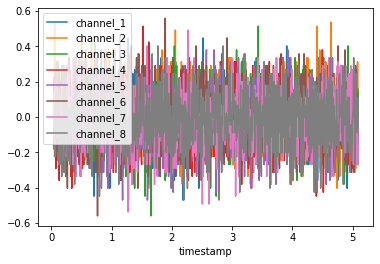

In [260]:
df = pd.DataFrame(data=channel_data.T).set_index(0)
print(df)
df *= 4.5
df /= (2**23)-1
df /= 24.0
df.columns = "channel_" + df.columns.astype(str)
df.index.name = "timestamp"
df.index -= min(df.index)
df.index /= 10**6
# df *= 1000000
df.iloc[10:].multiply(1e6).plot()



(array([24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16., 33., 33.,
        33., 34., 33., 33., 33., 34., 33., 33., 33., 34., 33., 33., 33.,
        34., 33., 33., 33., 33., 34., 33., 33., 33., 34., 33., 33., 33.,
        34., 33., 33., 33., 34., 33., 33., 33., 34.]),
 array([ 0.        ,  0.13277153,  0.26554306,  0.39831459,  0.53108612,
         0.66385765,  0.79662918,  0.92940071,  1.06217224,  1.19494377,
         1.3277153 ,  1.46048683,  1.59325836,  1.72602989,  1.85880142,
         1.99157295,  2.12434448,  2.25711601,  2.38988754,  2.52265907,
         2.6554306 ,  2.78820213,  2.92097366,  3.05374519,  3.18651672,
         3.31928825,  3.45205978,  3.58483131,  3.71760284,  3.850374

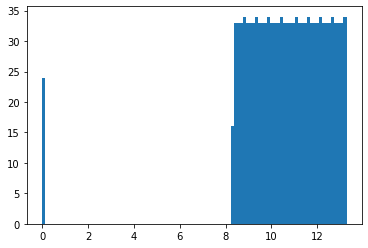

In [157]:
plt.hist(df.index.to_numpy(), bins=100)

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.005142391341017648

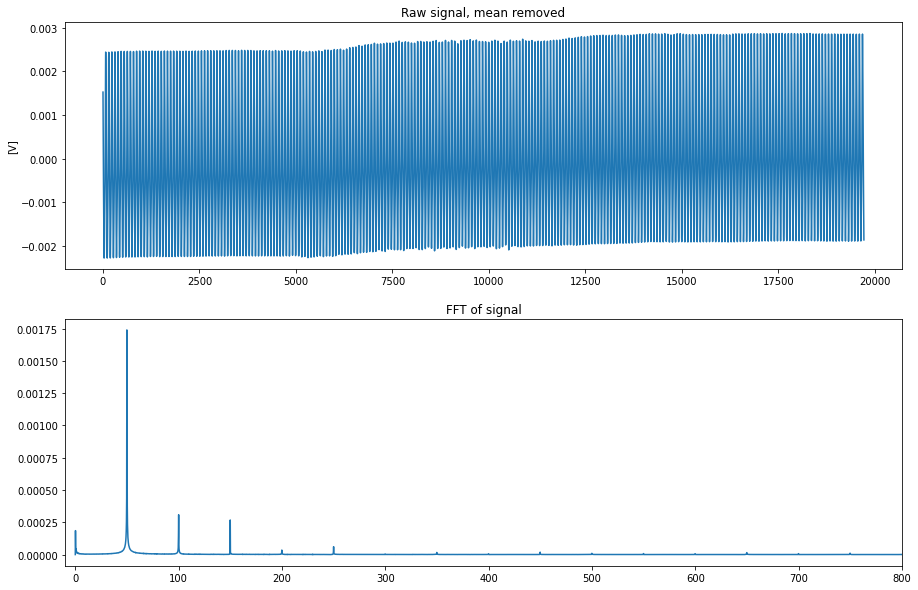

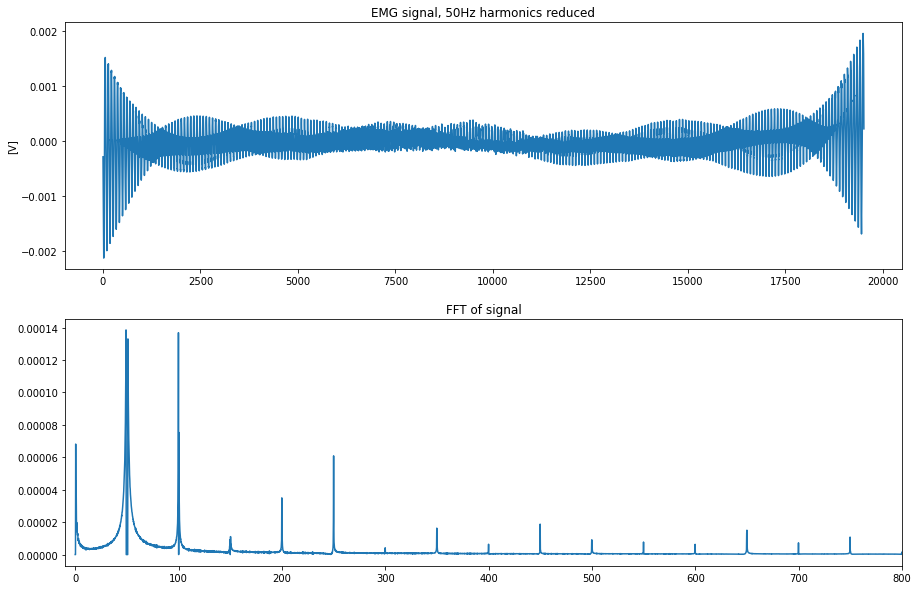

In [459]:
import scipy
from scipy import fftpack
sampling_rate = 4000
T = 1 / sampling_rate

y = df.channel_1
y = y.to_numpy()
y = y[100:]
y = y - y.mean()
N = len(y)
x = np.linspace(0.0, 1.0/(2.0*T), N//2)
y_fft = scipy.fftpack.fft(y)

psd = y_fft * np.conj(y_fft)/N

threshold = 0.0001
psd_idxs = psd < threshold
psd_clean = psd * psd_idxs
y_fft_clean = psd_idxs * y_fft
y_clean = scipy.fftpack.ifft(y_fft_clean)

y_fft = 2.0/N * np.abs(y_fft[:N//2])

fig = plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(y)
# plt.xlim(0,3710)
plt.title('Raw signal, mean removed')
plt.ylabel('[V]')
plt.subplot(2, 1, 2)
plt.plot(x, y_fft)
plt.xlim(-10, 800)
plt.title('FFT of signal')

y_fft_clean = 2.0/N * np.abs(y_fft_clean[:N//2])
y_clean = y_clean[100:-100]
fig = plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(y_clean)
# plt.xlim(10200,10700)
plt.title('EMG signal, 50Hz harmonics reduced')
plt.ylabel('[V]')
plt.subplot(2, 1, 2)
plt.plot(x, y_fft_clean)
plt.xlim(-10, 800)
plt.title('FFT of signal')
y.max() - y.min()


 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

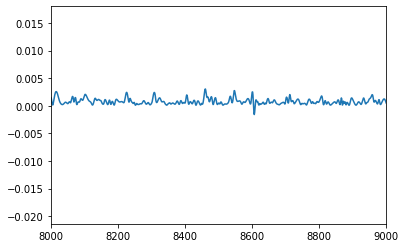

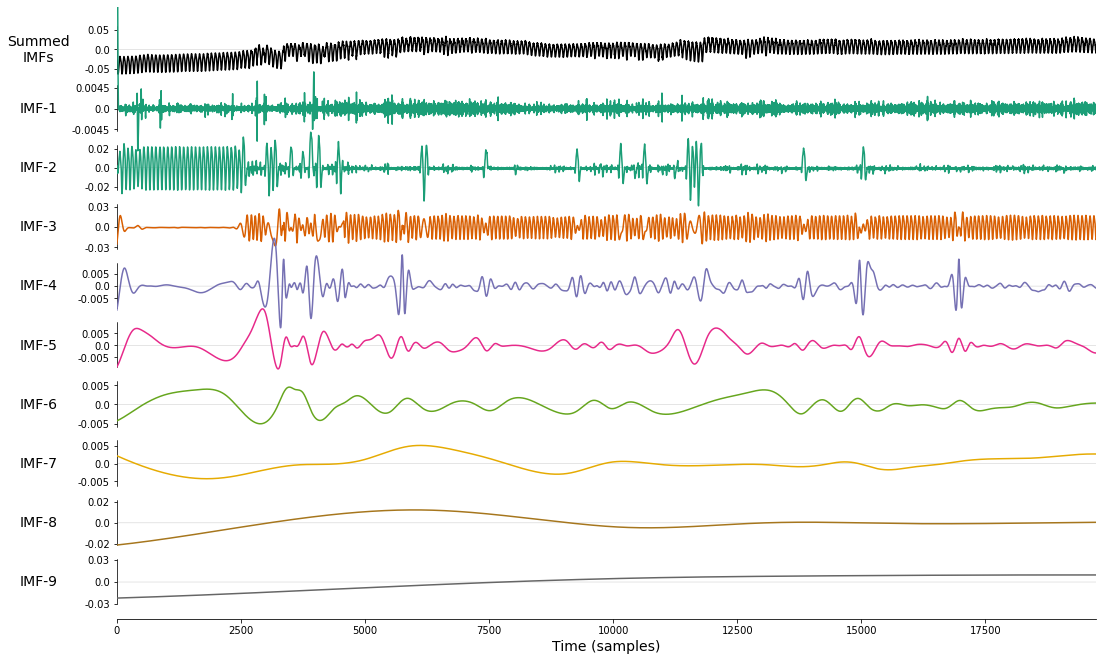

In [360]:
# EMD
import emd
seconds = 5
num_samples = seconds*sampling_rate

imf = emd.sift.sift(y - y.mean())
envelope = emd.sift.interp_envelope(imf, mode='upper')

plt.plot(envelope)
plt.xlim(8000,9000)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)

Text(0.5, 1.0, 'FFT after bandpass filtering')

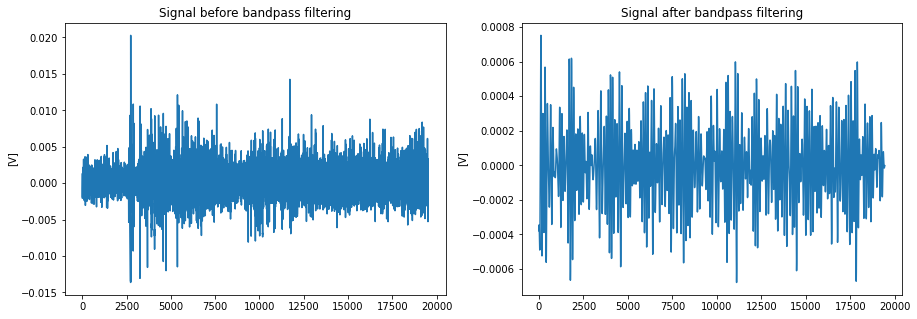

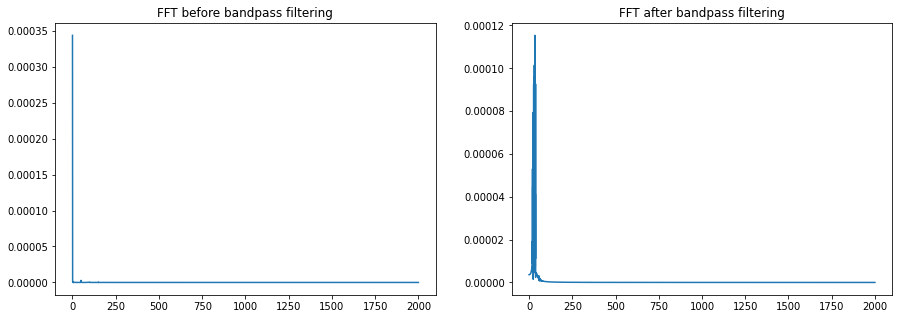

In [356]:
# Bandpass filter
from scipy import signal
high = 20/(sampling_rate/2)         # Normalized to Nyquist rate
low = 45/(sampling_rate/2)
b, a = scipy.signal.butter(4, [high,low], btype='bandpass')
y_butter = scipy.signal.filtfilt(b, a, y_clean)
# y_butter = abs(y_butter)

y_butter_fft = scipy.fftpack.fft(y_butter)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y_clean[1:])
# plt.xlim(7500,10000)
plt.title('Signal before bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(y_butter[100:])
# plt.xlim(7500,10000)
plt.title('Signal after bandpass filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.title('FFT before bandpass filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_butter_fft[:N//2]))
plt.title('FFT after bandpass filtering')


Text(0.5, 1.0, 'FFT after notch filtering')

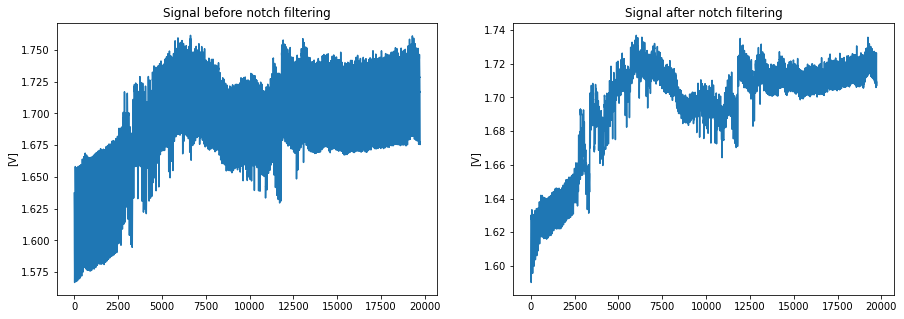

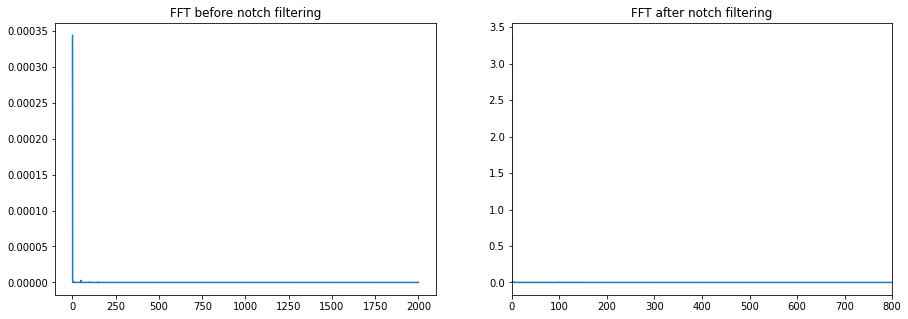

In [359]:
# Notch filter
from scipy import signal
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 10.0
b_notch, a_notch = scipy.signal.iirnotch(notch_freq, quality_factor, sampling_rate)

freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)

y_notched = scipy.signal.filtfilt(b_notch, a_notch, y)
y_notched_fft = scipy.fftpack.fft(y_notched)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y[1:])
plt.title('Signal before notch filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(y_notched)
# plt.xlim(2000, 2500)
plt.title('Signal after notch filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
# plt.xlim(0, 800)
plt.title('FFT before notch filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_notched_fft[:N//2]))
plt.xlim(0, 800)
plt.title('FFT after notch filtering')

Text(0, 0.5, '[V]')

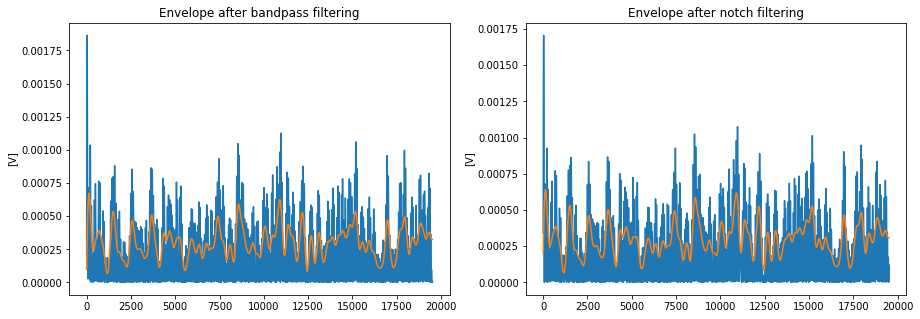

In [223]:
# Envelope
low_pass = 10/(sampling_rate/2)
b, a = scipy.signal.butter(3, low_pass, btype='lowpass')
envelope_b = scipy.signal.filtfilt(b, a, abs(y_butter))
envelope_n = scipy.signal.filtfilt(b, a, abs(y_notched))

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y_butter))
plt.plot(envelope_b)
plt.title('Envelope after bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(abs(y_notched))
plt.plot(envelope_n)
plt.title('Envelope after notch filtering')
plt.ylabel('[V]')

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

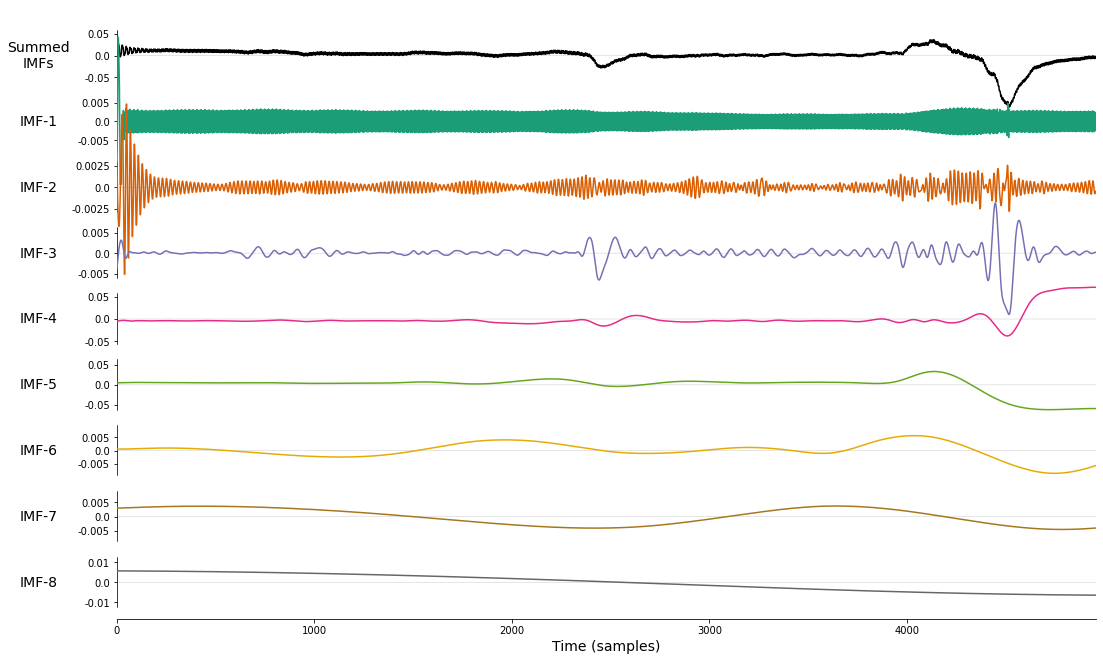

In [130]:
imf = emd.sift.sift(y_notched)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)